In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields, asdict
import itertools
from itertools import chain, product
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In file_utils.py: default_cache_path = /raid3/xd/.cache/torch/hub


In [3]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [4]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils import *
from child_utils import _cxt2str, _item2str, _s
from child_frames import *
with Timer('tasks'): from tasks import *
with Timer('model_utils_copy'): from model_utils_copy import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000027
utils ... done 0:00:00.002300
child_utils ... Loading tokenizer ... done 0:00:06.943508
done 0:00:13.282706
tasks ... done 0:00:00.001304
model_utils_copy ... done 0:00:00.834448
weight_analysis ... done 0:00:00.000028


In [5]:
torch.set_grad_enabled(False);

In [6]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
#cache_dir='/nas/wab/.cache/huggingface/transformers'
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [7]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['','google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']#wab
gpt_model_names = ['gpt2/cpu','gpt2-medium/cpu','gpt2-xl/cpu','EleutherAI/gpt-j-6B/cpu',]

for model_name in gpt_model_names[1:2]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 0
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 7; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer#, device

gpt2/cpu ... done 0:00:08.087979
EleutherAI/gpt-j-6B/cpu ... done 0:03:22.364742


In [8]:
model_name = gpt_model_names[3]
# model_name = engines[-1]
model, tokenizer = models[model_name]

In [9]:
blocks = model.transformer.h
for i, b in enumerate(blocks): b.layer = i
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].attn.num_heads, blocks[0].attn.embed_dim

# we = model.transformer.wte.weight.data
# wu = model.lm_head.weight.data

# es = [we]
# for b in blocks[:1]: es.append(es[-1] + mlp_forward(b, es[-1]))
# model.es = es
# weBTAs = [es[i].T @ es[i] for i in range(2)]
# model.weBTAs = weBTAs

In [10]:
device = torch.device('cuda:2')
_ = clone_model_to(model, device)

cloning GPTJBlock0.ln_1 to cuda:3 ... done 0:00:01.729739
cloning GPTJAttention.out_proj to cuda:3 ... done 0:00:00.027848
cloning GPTJBlock1.ln_1 to cuda:3 ... done 0:00:00.000881
cloning GPTJAttention.out_proj to cuda:3 ... done 0:00:00.019879
cloning GPTJBlock2.ln_1 to cuda:3 ... done 0:00:00.000753
cloning GPTJAttention.out_proj to cuda:3 ... done 0:00:00.018630
cloning GPTJBlock3.ln_1 to cuda:3 ... done 0:00:00.000733
cloning GPTJAttention.out_proj to cuda:3 ... done 0:00:00.017020
cloning GPTJBlock4.ln_1 to cuda:3 ... done 0:00:00.000735
cloning GPTJAttention.out_proj to cuda:3 ... done 0:00:00.017115
cloning GPTJBlock5.ln_1 to cuda:3 ... done 0:00:00.000736
cloning GPTJAttention.out_proj to cuda:3 ... done 0:00:00.016989
cloning GPTJBlock6.ln_1 to cuda:3 ... done 0:00:00.000481
cloning GPTJAttention.out_proj to cuda:3 ... done 0:00:00.016997
cloning GPTJBlock7.ln_1 to cuda:3 ... done 0:00:00.000740
cloning GPTJAttention.out_proj to cuda:3 ... done 0:00:00.016976
cloning GPTJBloc

In [11]:
sys.path.insert(0, '/nas/xd/projects/transformers/notebooks/wab/Easy-Transformer/easy_transformer')
from ioi_dataset import (
    IOIDataset,
)
N = 50
tokenizer.pad_token = tokenizer.eos_token
ioi_dataset = IOIDataset(
    prompt_type="mixed",
    N=N,
    tokenizer=tokenizer,
    prepend_bos=False,
) 

/nas/xd/projects/transformers/notebooks/wab/Easy-Transformer/easy_transformer/ioi_dataset.py:770: UserWarning: Some groups have less than 5 prompts, they have lengths [1, 2, 2, 1, 2, 3, 4, 4, 2]
  f"Some groups have less than 5 prompts, they have lengths {small_groups}"


In [12]:
r1 = None
result = {}

 ĠSamantha 0.012 {'Ġthe': 0.218, 'Ġhis': 0.129, 'Ġa': 0.013} 	 Then, Nathan and Samantha were thinking about going to the house. Nathan wanted to give a ring to Samantha *ĠSamantha:12.586 ĠNathan:9.876
4.41807746887207 0.0


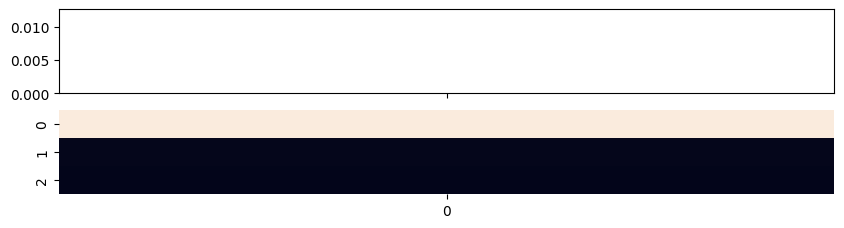

*ĠMelissa 0.272 {'ĠMelissa': 0.272, 'Ġthe': 0.216, 'Ġhis': 0.098} 	 Then, Melissa and Jason had a lot of fun at the restaurant. Jason gave a bone to Melissa *ĠMelissa:15.441 ĠJason:10.954
1.3017468452453613 1.0


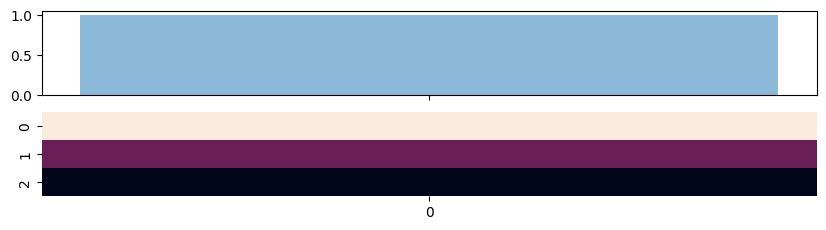

 ĠAlexander 0.038 {'Ġhis': 0.221, 'Ġthe': 0.21, 'Ċ': 0.078} 	 Then, Alexander and Charles went to the garden. Charles gave a kiss to Alexander *ĠAlexander:14.157 ĠCharles:11.107
3.280935287475586 0.0


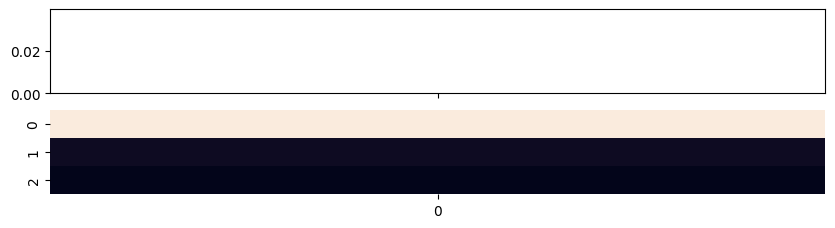

 ĠElizabeth 0.007 {'Ġthe': 0.237, 'Ġher': 0.146, 'Ġa': 0.05} 	 Then, Elizabeth and Michelle were thinking about going to the garden. Michelle wanted to give a ring to Elizabeth *ĠElizabeth:11.843 ĠMichelle:10.642
4.9645915031433105 0.0


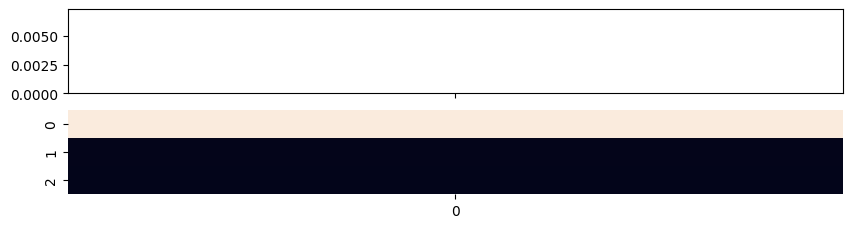

 ĠBrandon 0.035 {'Ġthe': 0.365, 'Ġall': 0.071, 'Ġa': 0.051} 	 Then, Samantha and Brandon had a lot of fun at the station. Samantha gave a snack to Brandon *ĠBrandon:13.981 ĠSamantha:9.326
3.3465194702148438 0.0


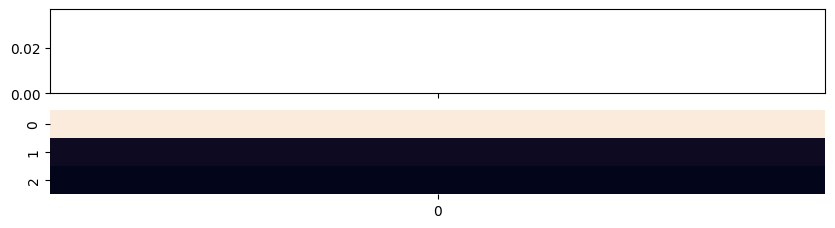

 ĠBryan 0.175 {'Ġa': 0.221, 'ĠBryan': 0.175, 'Ġthe': 0.125} 	 Then, Bryan and Thomas were working at the hospital. Thomas decided to give a kiss to Bryan *ĠBryan:15.406 ĠThomas:9.843
1.744580864906311 0.0


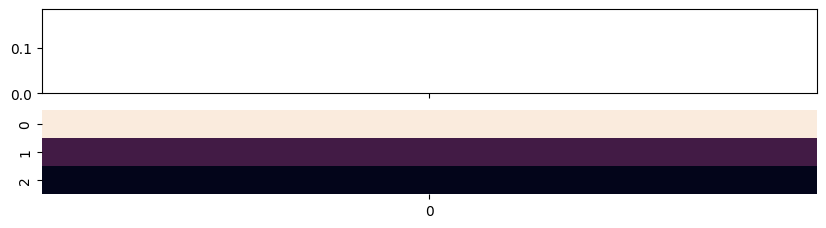

*ĠRyan 0.366 {'ĠRyan': 0.366, 'Ġthe': 0.095, 'Ġher': 0.079} 	 Then, Ryan and Laura were working at the garden. Laura decided to give a basketball to Ryan *ĠRyan:15.921 ĠLaura:11.216
1.0037858486175537 1.0


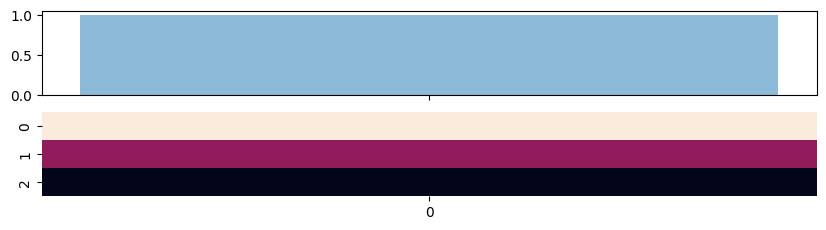

*ĠMichelle 0.337 {'ĠMichelle': 0.337, 'Ġthe': 0.202, 'Ġa': 0.06} 	 Then, Michelle and Heather went to the garden. Heather gave a drink to Michelle *ĠMichelle:15.773 ĠHeather:9.727
1.087210774421692 1.0


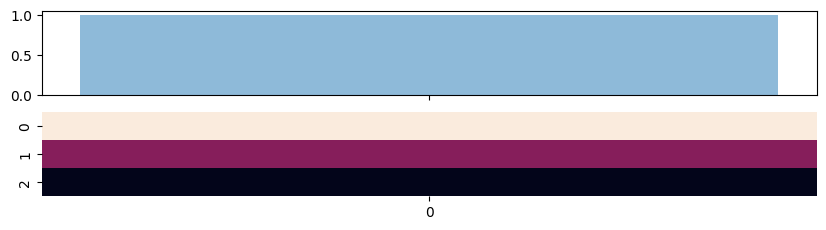

 ĠKevin 0.015 {'Ġthe': 0.279, 'Ġher': 0.112, 'ĠOfficer': 0.015} 	 Then, Kevin and Katie were thinking about going to the station. Katie wanted to give a kiss to Kevin *ĠKevin:13.026 ĠKatie:10.807
4.209329128265381 0.0


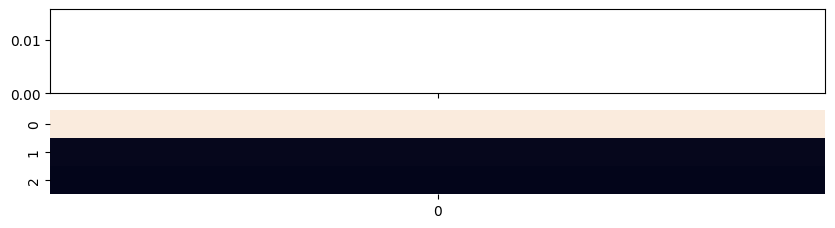

 ĠKatherine 0.113 {'Ġthe': 0.128, 'Ġme': 0.123, 'ĠKatherine': 0.113} 	 When Katherine and Bryan got a computer at the station, Bryan decided to give it to Katherine *ĠKatherine:14.901 ĠBryan:9.510
2.178746461868286 0.0


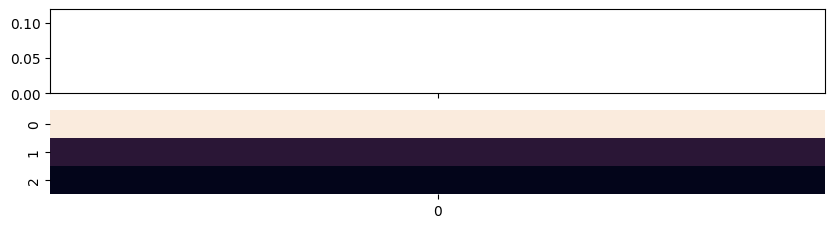

(2.7535523653030394, 0.3)

In [15]:
show_predictions_by_data_tuples(model, tokenizer, r1.data_tuples, k_shot=0)

In [20]:
cxt, query, cands, *_ = all_examples[0][0]

In [23]:
cxt, query, cands
all_examples[0][0]

('IO', 'IO-1', 'IO+1')

{'IO': tensor(4),
 'IO-1': tensor(3),
 'IO+1': tensor(5),
 'S': tensor(2),
 'S-1': tensor(1),
 'S+1': tensor(3),
 'S2': tensor(13),
 'end': tensor(19),
 'starts': tensor(0),
 'punct': tensor(12)}

Then, Nathan and Samantha were thinking about going to the house. Nathan wanted to give a ring to Samantha

In generate_and_predict_batch: predict ... labels = tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100, 34778,
          -100,  -100]])
labels_mask = tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])
new labels = tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100, 34778,
          -100,  -100]])
labels = tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100, 24164,  -100,
          -100]])
labels_mask = tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])
new labels = tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
     

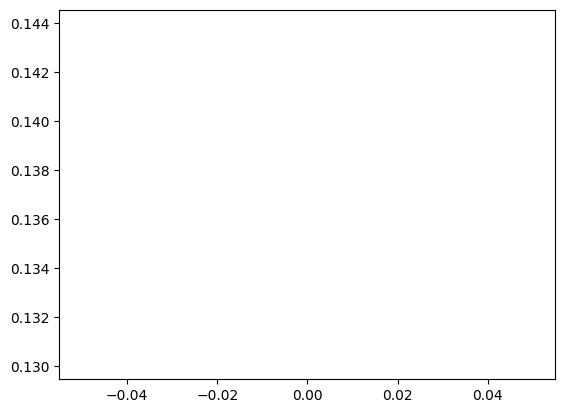

In [13]:
r1, all_examples = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=10,ioi_dataset = ioi_dataset,
                                        trim=False, result=r1, verbose=False)

In [16]:
if True or r1.root is None: r1.root = add_node(None, layer=L, label_type='labels')
r1.root = attribute_tree_on(r1.data_tuples, model, r1.root, 0, topk=10, k_shot=0, mix=True, device=device, verbose=True)

attribute_tree ... In attribute_tree: attribute_step , topk=10 ... done 0:00:01.591686
In attribute_tree: attribute_step stage2  ... done 0:00:00.060798
In _add_node: add @0 19-6 100 B->A0 97/37 attn/ans0s
In _add_node: add @2 21-6 46 B->A0 46/30 attn/ans0s
In _add_node: add @4 20-8 33 B->A0 98/27 attn/ans0s
In _add_node: add @1 20-2 68 B->s2 94/67 attn/example
In _add_node: add @3 13-4 34 B->s2 88/34 attn/example
In _add_node: add @5 24-10 31 B->s2+ 36/10 attn/example
In _add_node: add @475 21-15 -40 B->A0/43/0 attn/ans0s
In _add_node: add @20 14-6 10 B->A0/30/0 attn/ans0s
In _add_node: add @[0,2,4,6,8] 19-6,21-6,20-8,16-0 28,19-12 18 B->A0 34
In _add_node: add @[1,3,7,9] 20-2,13-4,21-2 26,16-9 17 B->s2 22
In _add_node: add @[5] 24-10 B->s2+ 3
In _add_node: add 19-6,21-6,20-8 B->A0 attn/ans0s
In _add_node: add 14-6,21-15 B->A0 attn/ans0s
In attribute_tree: attribute_step 19-6,21-6,20-8 B->A0 attn/ans0s, topk=8 ... done 0:00:00.432658
In attribute_tree: attribute_step stage2 19-6,21-6,

In [17]:
print_tree(r1.root)

 ┌@[0,2,3,4,5,9] 19-6,19-0,20-8,21-14,16-0,14-6 29 B->A0 20
 ├@[8] 25-16 B->B 10
 ├@[1,6,7] 20-2,13-4,21-2 B->s2 5
 ├@0 19-6 100 B->A0 38/35 attn/ans0s
 ├@2 19-0 53 B->A0 39/37 attn/ans0s
 ├@3 20-8 47 B->A0 39/27 attn/ans0s
 ├@4 21-14 44 B->A0 17/15 attn/ans0s
 ├@5 16-0 37 B->A0 39/14 attn/ans0s
 ├@474 24-6 -34 B->A0/31/0 attn/ans0s
 ├@475 21-15 -46 B->A0/46/0 attn/ans0s
 ├@8 25-16 34 B->B/100
 ├@1 20-2 60 B->s2 37/68 attn/example
 ├@6 13-4 37 B->s2 38/48 attn/example
 ├@7 21-2 34 B->s2 38/52 attn/example
 ┤
 │                              ┌@[4,5] 18-16,18-9 25 B->B 17
 │                              ├@[0,1,3,6] 13-4,11-15,15-11,14-13 18 B->s2 14
 │                              ├@[7] 17-9 15 B->s1 3
 │                              ├@[2] 13-2 unk 0
 │                              ├@4 18-16 32 B->B/100
 │                              ├@0 13-4 100 B->s2 37/48
 │                              ├@1 11-15 65 B->s2 32/20
 │                              ├@3 15-11 39 B->s2 13/6
 │                

In [ ]:
node = r1.root.children[-1]
plot_attn_attrs(r1.data_tuples[:1], model, tokenizer, node, topi=[0], attn_patterns=['B->S'], k_shot=0)